# Training a Neural Network

## What does it mean to train a neural network?
<div>
<img src="https://s3.us-east-2.amazonaws.com/mxnet-zoo/public/machine_learning_2x.png" style="width: 30%;">
<center>Credit XKCD</center>
</div>

While it may appear silly at first, this is really close to the heart of training a neural network.

The notebook on neural network layers hopefully made it clear why describing machine learning as a buch of linear algebra isn't too far off. We will not shift our focus to training models instead of just building them. To avoid too much enjoyment, we will transition from building neural networks by hand and start using the high-level gluon package.

## Goal
In this notebook you will create a neural network with the intent of identifying people by their faces. To keep things simpler we will pick a single individual (the target) and create a neural network to determine if an image of a person's face is an image of the target.

## Let's start by importing some useful libraries.

In [1]:
import mxnet as mx
from mxnet import nd, autograd #nd is an array library similar to numpy, autograd will be used for gradients
from mxnet import gluon #gluon is the high-level api that will save us many keystrokes
import numpy as np #our good friend numpy that you should be familiar with by now
import requests
import os
import shutil #package we will use to move files
import tarfile
import io
import skimage
from skimage import io as imageIO #module used to load images need to change the name to avoid conflicts
import matplotlib.pyplot as plt
from glob import glob #a handy tool for getting files in folders
%matplotlib inline
mx.random.seed(1) #set the random seed so that answers can be repeatably random

## Get some data

In [2]:
url = 'http://vis-www.cs.umass.edu/lfw/lfw-a.tgz'
base = os.getcwd()
tmp = 'faces' #specify a location to store the images we will work with
loc = os.path.join(base, tmp)
if not os.path.isdir(loc): #make a directory to store the images in
    os.mkdir(loc)
r = requests.get(url)
if r.status_code == 200: #if the GET request is successful
    hold = io.BytesIO(r.content)
    f = tarfile.open(fileobj=hold) #load the tarfile into a tarfile object for extraction
    f.extractall(loc)
    people = os.listdir(os.path.join(loc, 'lfw'))

if people:
    print("We now have {} folders with images of different people's faces".format(len(people)))

We now have 432 folders with images of different people's faces


## Determine who has the most images, this will be our target individual.

In [3]:
most = [0, '']
for folder in people:
    path = os.path.join(loc, 'lfw', folder)
    num = len(os.listdir(path))
    if num > most[0]:
        most[0] = num
        most[1] = folder
        
print('{} has the most pictures with {}'.format(most[1], most[0]))

Ariel_Sharon has the most pictures with 77


### Take a look at some images of Ariel

The image dimensions are  (250, 250, 3)


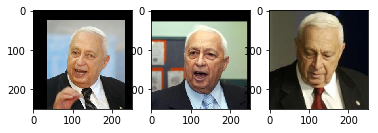

In [5]:
positive_paths = glob(os.path.join(loc, 'lfw',most[1],'*'))
f, (ax1, ax2, ax3) = plt.subplots(1, 3)
example = imageIO.imread(positive_paths[0])
print("The image dimensions are ", example.shape)
ax1.imshow(example)
ax2.imshow(imageIO.imread(positive_paths[1]))
ax3.imshow(imageIO.imread(positive_paths[2]))

## Prepare the images
Since Ariel is our target, we will make a new directory to store the images in. The structure of this directory will tell us what the label of each image is with labels being either Ariel or not Ariel. In this way we do not need to store extra information in the image to determine what category the image belongs in.

In [6]:
image_root = 'target_ariel'
image_root = os.path.join(loc, image_root)
positive = os.path.join(image_root, 'positive')
negative = os.path.join(image_root, 'negative')
if not os.path.isdir(image_root):
    os.mkdir(image_root) #create the new root folder
    
if not os.path.isdir(positive):
    os.mkdir(positive) #folder to hold all of the pictures of Ariel
    
if not os.path.isdir(negative):
    os.mkdir(negative) #folder to hold pictures of everyone else
    
#now loop over all of the images and copy them to the appropriate folder
for folder in people:
    path = os.path.join(loc, 'lfw', folder)
    images = glob(os.path.join(path, '*.jpg'))
    if folder is not most[1]:
        dest = negative
    else:
        dest = positive
    for image in images:
        shutil.copy2(image, dest)

num_positive = len(os.listdir(positive))
num_negative = len(os.listdir(negative))
#Print out some results to verify that everything worked as expected
print('The number of positive images is {}'.format(num_positive))
print('The number of negative images is {}'.format(num_negative))

The number of positive images is 77
The number of negative images is 977


## Create a data generator
Data generators are analogous to generators in python. The idea is that every time you ask the generator for images it will give you images according to some predetermined rules. Here we will use tools built into gluon to accomplish the task.

In [7]:
#Define a function to transform the images into the expected shape (N, channels, H, W) 
#and normalize the input channels
def transformer(data, label):
    return nd.transpose(data.astype(np.float32), (2,0,1))/255, np.float32(label)

test_fraction = 0.3
train_dataset = mx.gluon.data.vision.ImageFolderDataset(image_root, transform=transformer)
test_dataset = mx.gluon.data.vision.ImageFolderDataset(image_root, transform=transformer)
print("The image classes are: ", train_dataset.synsets) #The classes are determined from our folder structure
print("The total number of images is: ", len(train_dataset.items))

i = train_dataset.items #all images are contained here and need to be split into training and testing
indicies = np.arange(len(i)) #list of all indicies in the data
num_test = int(test_fraction * len(i)) #the number of samples to hold out for testing
test_indicies = np.random.choice(indicies, num_test, replace=False) #randomly choose the testing set
train_indicies = set(indicies) - set(test_indicies) #determine the remaining samples
test_dataset.items = [i[x] for x in test_indicies] #create the test data loader
train_dataset.items = [i[x] for x in train_indicies] #create the train data loader

#print out the lengths to verify we have the correct amount
print("Number of training images: ", len(train_dataset.items))
print("Number of testing images: ", len(test_dataset.items)) 

batch_size = 50 # Number of images to analyze at one time
#Now that we have our data we load it into a more general data generator
train_dataloader = mx.gluon.data.DataLoader(train_dataset,
                                            batch_size=batch_size,
                                            shuffle=True,
                                            sampler=None,
                                            last_batch=None,
                                            batch_sampler=None)
test_dataloader = mx.gluon.data.DataLoader(test_dataset,
                                           batch_size=batch_size,
                                           shuffle=False,
                                           sampler=None,
                                           last_batch=None,
                                           batch_sampler=None)

The image classes are:  ['negative', 'positive']
The total number of images is:  1054
Number of training images:  738
Number of testing images:  316


## Train test split
This is one of the most important aspects of creating any supervised machine learning algorithm. You absolutely must separate your input data into a training set and a testing set at a minimum. It's actually even better to separate your data into train, test, and validate data sets. We don't do that here due to the size of the dataset and the fact that this model will not go into production.

### Overfitting
We separate our data into different sets to help avoid one of the primary evils in machine learning, overfitting. Overfitting is when a model learns the detailed intricacies of the data it was trained on. This is actually a bad thing (assuming that your training dataset doesn't have all possible examples in it that your model could ever encounter) because the model will now fail to generalize. 

As an example, pretend that you are playing a card game with some friends, and you are using an old deck of cards. As you begin playing the game you notice that all of the aces in the deck have a noticeable fold crease in the cards. You learn to spot this crease and are therefore capable of predicting when a card will be an ace based on this crease. This ability to detect aces is analogous to a machine learning model that has been overfit. While you will be able to detect aces with 100% accuracy in this old deck of cards, you will have very little success detecting aces by the same method on a brand new deck of cards. In the same way, models must not be pushed in the direction of generalization.

We will come back to the idea of overfitting later, but just remember at this point that splitting our dataset is the first line of defense against overfitting.

## Define the neural network
We will now actually define the neural network that will be used to examine the images. Hopefully you agree that this gluon thing is a lot nicer than building everything from scratch!

In [8]:
net = gluon.nn.Sequential() #Instantiate an object to hold the description of our network
with net.name_scope(): #This tells gluon to keep the naming consistent for these layers
    net.add(gluon.nn.Conv2D(channels=20, kernel_size=5, activation='relu'))
    net.add(gluon.nn.MaxPool2D(pool_size=2, strides=2))
    net.add(gluon.nn.Conv2D(channels=50, kernel_size=3, activation='relu'))
    net.add(gluon.nn.MaxPool2D(pool_size=2, strides=2))
    # The Flatten layer collapses all axis, except the first one, into one axis.
    net.add(gluon.nn.Flatten())
    net.add(gluon.nn.Dense(1000, activation="relu"))
    net.add(gluon.nn.Dense(1))
    

### Questions
1. Can you diagram out the layers in this model? Hint, not all layers are as conspicuous as others.
1. What is the top (last) layer of the network?
1. Why does the top layer have the number of neurons described?

### visualize the network
If it's difficult for you to see the network based on the above code, gluon comes with a handy method to display the network graphically.

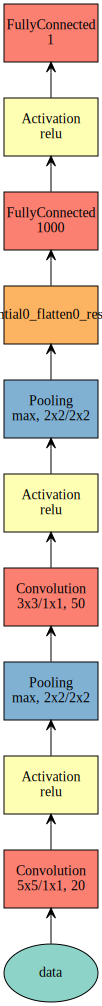

In [9]:
#The visualiztion package was included in mxnet before gluon. As such it expects an older method of defining the
#neural network to be imported. This older method is called symbol. To get the symnbol representation we make
#a symbol to define our data and then run that symbol through the network. The output is a symbol that represents
#the entire network
inputs = mx.sym.var('data')
out = net(inputs)

mx.viz.plot_network(out)

## Parameter initialization
When we built our nerual networks from scratch we used the numpy functions numpy.ones and numpy.zeros. This created arrays that were initialized with all ones or zeros. While we are not creating these arrays explicitly in our gluon-based neural network, there are still arrays holding weights and biases. All of the parameters in these arrays need to have some initial value before we can begin training the neural network.

There has been substantial effort devoted to understanding how parameters should be initialized for neural networks. In the worst scenario poor paramter initialization will prevent the model from fitting, but for simple networks like the one we defined above, poor initialization will likely just increase the amount of time the model needs to train.

Each layer in the neural network with weights or bias parameters can have its own parameter initialization method which can be specified when the neural network is defined. The entire network can also be initialized with a single method. While there are different strategies behind how to initialize parameters, the overarching goal is the same: ensure that whatever parameters are chosen at the input of the model remain reasonable as they traverse each layer of the neural network. As all of the linear algebra is performed when stepping through a neural network it's possible that some parameters end up tending towards an infinity or zero. In the former case, the algorithm may run into computation issues. In the latter case, the neural may go 'dead' since anything times zero is still zero.

### Initialization options
Mxnet comes prepackaged with a number of initialization options. Below are some of the choices:
* Zero
* One
* Constant
* Uniform
* Normal
* Orthogonal
* Xavier
* MSRAPrelu

The reader is encouraged to read up on the different initialization options, but we will not discuss them here.

### Initialize the parameters
The initializer requires two arguments, the initialization method to use and the context. Below we choose Xavier initialization and set the context to be mx.cpu. Think of the context as where you want the model to run. We use cpu below since all machines have a cpu. If you are working on a machine with an applicable gpu, you can change the context and reap the bennefits of faster training.

In [10]:
ctx = mx.cpu()
net.collect_params().initialize(mx.init.Xavier(magnitude=2.24), ctx=ctx)

## What is the value of a model?
While it may be ovious to assume that not all models are equal in their predictive abilities, the question remains, how does one measure how well a model performs? The current solution is to use a loss function.

### Loss
How we define a correct prediction has major rammifications on the results of the model. The method used to define model correctness is termed the loss. In the case of least squares analysis, the loss function is the squared difference between the model output and the correct output. This basic loss function is zero when the prediction is correct and increases as the prediction gets farther (in any direction) from the truth. With such a function, we can calculate a number that tells us how well the model is behaving. We can also determine if making certain changes to the model makes it a better or worse model. This leads us to a working definition of the loss function.

**Loss function:**  A function with the neural network and ground truth as the input and outputs a value that measures how closely the model is matching the ground truth.

Generally loss functions are defined such that the minimum output value is zero meaning a perfect model. As the model deviates from ideality the output of the loss function increases.

While the user can define any loss function they want, gluon has a number of commonly used loss functions baked in:
* HybridBlock
* KLDivLoss
* L1Loss
* L2Loss
* Loss
* SigmoidBCELoss
* SigmoidBinaryCrossEntropyLoss
* SoftmaxCELoss
* SoftmaxCrossEntropyLoss

Since we are interested in a model that predicts either yes or no, we will use the Sigmoind Binary Cross Entropy loss function. This function applies a sigmoid function to the neural network output and then calculates the binary cross entropy (see https://en.wikipedia.org/wiki/Cross_entropy for more details).

#### Specify the loss function

In [11]:
cross_entropy = gluon.loss.SigmoidBinaryCrossEntropyLoss()

## Optimization
Now that we have a value describing how well our model is performing, we need a means of making the model perform better. When we first instantiate the model it is almost impossible that the parameters we choose at the beginning will be the best parametrs for the model. As such we need a way to make the model perform better. Since there is no known method of calculating the best parameters we need to use a method of intelligent guess and check.

### Stir the pile
As the cartoon suggested at the start of this notebook, we need to stir our linear algebra pile to get better outputs. There are a number of different methods used to stir the pile, but we will examine the basic theory instead of getting into the weeds with some of the more complex methods.

Let's begin with a simple one dimensional problem and leave it to your imagination to undertand a multi-dimensional analogue. Imagine that we have calculated the loss for our fictitious model and the result looks like the following:
<img src="https://s3.us-east-2.amazonaws.com/mxnet-zoo/public/errorPlot_start.png" style="height: 400px">

Suppose that the parameter we chose to initialize the model with ($x_0$) put us at the blue circle with a high value of the loss function, $L\left(x_0\right)$. The goal then is to make it to the global minimum at $x_{ideal}$.

#### Remember calculus I
If you remember back to Calc. I, a good portion of that class was likely devoted to finding local minima and maxima of functions. When you know the function description, let's use $f\left(z\right) = \left(z-2\right)^2 + 4$ as our example function, we can find the lcoal minima and maxima by taking the derivative and setting it equal to zero.
$$
\frac{df}{dz} = 2z - 4 = 0 \Rightarrow z = 2
$$

For the case of this test function, the critical point of the funciton occurs at $z=2$. If we were to use the second derivative to check the concavity we would find that this is a minimum of the function.

#### What if we don't know the function?
In reality, we never have a simple mathematical description for the loss function of our neural network that we can symbolically take the derivative of. While we could theoretically calculate the value of our loss function for a large number of potential inputs to make a map similar to the plot above, the computational cost of such an effort would be prohibitively expensive. 

What we can do though is calculate the derivative at a single point. While this calculation can still be expensive, this is about the minimum amount of computation we can perform and still have a hope of optimizing the function. If we calculate the derivative of our function at the starting point, we will see that the function is decreasing if we increase $x$ and increasing if we decrease $x$. This tells us that we likely want to make $x$ larger if we are to find the minimum.

The derivative at our starting point has told us to move to the right of the plot, but now we must decide how far to the right to step. We could step as far as we want, but there are consequences to the step length we choose. The image below shows where we would end up if we pick different step sizes.
<img src="https://s3.us-east-2.amazonaws.com/mxnet-zoo/public/errorPlot_stepsize.png" style="height: 400px">

Remember, since it's too expensive to calculate the entire curve, when looking at the image above we don't know where we will end up if we pick any of the step sizes. There is a huge amount of work focused on finding the best step size to make the algirthm find the minimum fastest. We won't focus on those here, but you are welcome to learn about step sizes on your own.

#### Local minima
What do we do if we pick the middle step size above and end up in the local minima? If we calculate the derivative at the local minima we will find ourselves in a situation described by the image below.
<img src="https://s3.us-east-2.amazonaws.com/mxnet-zoo/public/errorPlot_localmin.png" style="height: 400px">

The problem here is that the derivative tells us that moving in both directions would be bad as each direction increases the loss. In a world where we do not know about the global minimum, we might be satisfied with this result and decide that our funciton has found the best possible loss value. However, in this case we know that the loss value is only a local minima and we need to make our algorithm smart enough to get out of this pickle.

#### Momentum
One interesting approach to solving the problem of local minima is termed momentum. The idea is best understood with a picture.
<img src="https://s3.us-east-2.amazonaws.com/mxnet-zoo/public/errorPlot_momentum.png" style="height: 400px">

Pretend that our loss function is a child on a sled. The child starts at the top of the hill where the blue circle was. Just like our optimization function the child moves in the direction the minimizes the derivative. The question now is, what happens when the child reaches the local minimum? Given the drawing, it appears that the child should have enough momentum built up to climb over the small hill and make it to the global minimum. A similar approach can be used in code where the location is treated like a child on a sled. The momentum of the child is calculated at each stop and steps are taken uphill so long as there is enough momentum built up to justify it.

### Define the optimizer to use
We will use the Adam optimizer which uses a number of fancy techniques beyond the ones described above.

In [12]:
trainer = gluon.Trainer(net.collect_params(), 'adam')

### Calculate the accuracy
It's always nice to know how accurate our model is. We will need a function that we can call to tell us how accurate our model is. Let's create one below.

In [13]:
def evaluate_accuracy(data_iterator, net, weight=0.0):
    acc = mx.metric.Accuracy()
    for i, (data, label) in enumerate(data_iterator):
        data = data.as_in_context(ctx)
        label = label.as_in_context(ctx)
        sample_weight = label * weight + 1
        output = net(data)
        predictions = nd.round(1/(1 + nd.exp(-1 * output))) #apply sigmoid function and round
        acc.update(preds=predictions, labels=label)
        loss = cross_entropy(output, label, sample_weight) 
    return acc.get()[1], nd.mean(loss).asscalar()

## Backpropagation
To make progress we need to go backwards. In the above discussion on optimization we assumed that we could calculate the gradient to optimize the network. We left out one important point though. What gradient are we talking about? A neural network has many layers and each of those layers needs to be optimized.

Let's first start with the top layer of the network. This top layer has an output that we are comparing to the expected output using our loss function. When we calculate the loss, we then have an error. This erro can be used to calculate the gradients in the top layer and use that to determine how to change the weights of the top layer to get closer to optimization.

Once the top layer has been optimized we take a step backward into the layer. An estimate of an idea input into the last layer is given by the ideal output moved backwards through the top layer. Once we calculate this value, we can now perform the same math as used before on the top layer.

### Vanishing Gradients
A major problem with backpropagation is the occurence of vanishing gradients. We will explore below how the choice in activation function can drastically impact the gradient in backpropagation. Let's first examine what can happen if we use a sigmoid activation.

<div>
<img src="https://s3.us-east-2.amazonaws.com/mxnet-zoo/public/sigmoid_back.png">
<center>Credit https://medium.com/@karpathy/</center>
</div>

In the above image, we see the sigmoid function and the derivative of the sigmoid function. If the input to the sigmoid function is either very large or small, the gradient will be very close to zero and backpropagation will be unable to determine which direction to change the parameters to get a better result.

A similar problem can happen with a RELU.
<div>
<img src="https://s3.us-east-2.amazonaws.com/mxnet-zoo/public/relu_back.png">
<center>Credit https://medium.com/@karpathy/</center>
</div>

### The moral
* Proper initialization can be important to ensure that a network does not fall into the trap of having too many vanishing gradients. 
* Be thoughtful about what layers you add to your network in terms of how they might impact backpropagation

### What is the code doing?
When models are being trained the python interpreter changes between handling higher level details, like loading data from the specified files while c or cuda code does the heavy lifting. This enables a substantial speed up over running everything within the python interpreter.

It is often handy to know what your code is up to while it is running, especially since these models can take a long time to train. The following function will print us some useful information to watch as the model trains.

In [14]:
def progress_bar(epoch, percentage, loss):
    num_equals = int(percentage // 5)
    num_spaces = 20 - num_equals
    msg = ('\rEpoch: ' + 
        str(epoch) + 
        ' [' + '='*num_equals + 
        ' '*num_spaces + '] {}%'.format(str(np.round(percentage, 2)).zfill(2)) +
        '   Loss: {}'.format(loss)
    )
    print(msg, end='')

## The training loop
Neural networks often need to see the data multiple times before they are fully optimized. This means that we must loop over all of the training data, pass it through the model, calculate the loss, and then update the model. In practice we generally cannot train the model on all of the training data at once so we use batches of training data, one at a time. If you recall the batch_size parameter we defined earlier, this is exactly where that parameter comes into play. 

Below we have defined the steps of a training loop. Execute the following code and watch your model begin to learn!

In [15]:
epochs = 1
smoothing_constant = .01

for e in range(epochs): #loop through each epoch
    for i, (data, label) in enumerate(train_dataloader): # train on each batch of data
        data = data.as_in_context(ctx) # get the data as stored in the proper context
        label = label.as_in_context(ctx)
        with autograd.record(): # start recording in order to calculate the gradients
            output = net(data)
            loss = cross_entropy(output, label)
        loss.backward() # backpropogate the loss
        trainer.step(data.shape[0]) # take a step along the gradient to make the model better

        # Record where the loss is at
        curr_loss = nd.mean(loss).asscalar()
        moving_loss = (curr_loss if ((i == 0) and (e == 0))
                       else (1 - smoothing_constant) * moving_loss + smoothing_constant * curr_loss)
        progress_bar(e, 100 * i/len(train_dataloader), moving_loss)
        
    test_accuracy, test_loss = evaluate_accuracy(test_dataloader, net)
    train_accuracy, train_loss = evaluate_accuracy(train_dataloader, net)
    print('\n')
    print("Epoch %s. Loss: %s, Train_acc %s, Test_acc %s" % (e, moving_loss, train_accuracy, test_accuracy))

Epoch: 0 [=                   ] 6.67%   Loss: 0.7253190958499909

KeyboardInterrupt: 

## How good is our model?
It's time to stop and think a little bit about the performance of our model that we have begun training.

#### Questions
1. How accurate is the model?
1. Should that accuracy be considered respectable?
1. Suppose I build a coin flipping robot to take the place of our model. How much better/worse would this robot model be?
1. What if I built a Magic 8 Ball that could only say versions of no and used that in place of our neural network. Which model would perform better?

### Beyond accuracy
While accuracy can be an important metric for determining how well a model is performing, the accuracy cannot be taken out of context. Specifics about the problem can greatly impact how we should feel about a given accuracy. There are some problems where 60% accuracy may be really good and others where that accuracy is worse than random chance.

### Class imbalance
It is rather common that the number of examples we have for every class is not the same. Our current model suffers from this imbalance. There are roughly 10 times more negative images than positive images. If we don't help our model understand this class imbalance, the model may decide to always predict negative. To combat this behavior we can tell our loss function to punish the model extra harshly for any false negatives that it predicts. This is what we do in the next cell.


In [64]:
weight = (len(train_dataloader) * batch_size) / num_positive
weight = weight - 1 # This will offset a one that we add back later

epochs = 2
smoothing_constant = .01
losses = []
test_losses = []

for e in range(epochs): #loop through each epoch
    for i, (data, label) in enumerate(train_dataloader): # train on each batch of data
        data = data.as_in_context(ctx) # get the data as stored in the proper context
        label = label.as_in_context(ctx)
        sample_weight = label*weight + 1 # Since the negatives are zero and positives are 1 this works
        with autograd.record(): # start recording in order to calculate the gradients
            output = net(data)
            loss = cross_entropy(output, label, sample_weight) # Now the sample weight is included
        loss.backward() # backpropogate the loss
        trainer.step(data.shape[0]) # take a step along the gradient to make the model better

        # Record where the loss is at
        curr_loss = nd.mean(loss).asscalar()
        moving_loss = (curr_loss if ((i == 0) and (e == 0))
                       else (1 - smoothing_constant) * moving_loss + smoothing_constant * curr_loss)
        progress_bar(e, 100 * i/len(train_dataloader), moving_loss)
    
    losses.append(moving_loss)
    test_accuracy, test_loss = evaluate_accuracy(test_dataloader, net, weight=weight)
    test_losses.append(test_loss)
    
    print('\n')
    print("Epoch %s. Loss: %s, Train_acc %s, Test_acc %s" % (e, moving_loss, train_accuracy, test_accuracy))

Epoch: 000 [==================  ] 93.33%   Loss: 0.10824091722587648

Epoch 0. Loss: 0.108240917226, Train_acc 0.960704607046, Test_acc 0.939873417722
Epoch: 001 [==================  ] 93.33%   Loss: 0.11214952611691603

Epoch 1. Loss: 0.112149526117, Train_acc 0.960704607046, Test_acc 0.936708860759


## Learning
Now that we have trained our model for a number of epochs we can start to get an appreciation for the rate at which the model is learning. An added bennefit of plotting out the loss over time is that we can start to extrapolate how much more time is needed for the model to reach a desired loss (if it ever will).

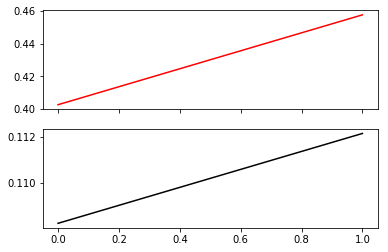

In [70]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
ax2.plot(np.arange(epochs), losses, 'k')
ax1.plot(np.arange(epochs), test_losses, 'r')

## Overfitting
The above plots can be very helpful for determining when a model is overfitting. Recall that overfitting means a model is failing to generalize. It instead learns the specifics of the training data set. If the loss is decreasing with each epoch, but the test_loss is not decreasing or begins to increase, this is a sing that the model has started to overfit.

In some cases you may want to save the weights when the model performed best on the test dataset. In other cases it might be best to re-engineer the model to help combat overfitting. There are a number of tools to combat overfitting and we will explore a few of them now.

### Simpler models
Perhaps the most trivial way to combat overfitting is to make a simpler model. The simpler the model (fewer layers or fewer parameters) cannot learn as complicated patterns as a more complex model. If the model is sufficiently simple, it will be entirely unable to overfit the data. However, if the model is too simple, it will be incapable of learning the trends in the data for which the model was designed. When designing models it can be best to start simple and build up until you reach the point of overfitting. This is generally an easier and faster strategy than trying to go really deep at first and then simplify.

In some cases it's not easy to find a model that is simple enough to avoid overfitting but complicated enough to learn the desired behavior. In these cases other methods must be employed to combat overfitting.

### Dropout layers (gluon.nn.Dropout)
The dropout layer is a simple layer that works somewhat like random amnesia for the neural network. Whenever a dropuout layer recieves input, it randomly decides which parts of the input to pass onto the next layer. While the specific inputs that the dropout layer passes are chosen randomly, the layer always sends through the same fraction of the inputs so that the next layer knows what to expect for input.

The random nature of the dropout layer prevents a network from relying too much on any single signal. This helps to prevent the network from being too specific.

### Normalization layers (gluon.nn.BatchNorm)
Batch normalization layers perform normalization on the input. This ensures that the output of the normalization layer does not have any values that are extremely large or small. It also pushes the standard deviation close to unity. The normalization limits how impactful a single signal can be. These layers are also very helpful in training deep networks becuase they urge the graidents to stay well behaved.
